# AC_SDSS_PTF_CRTS_offsets

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import Column
from astropy.table import join
import celerite
import modules as mod
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18


In [25]:
#address = '../../CRTS_PROJECT/data_products/CRTS_SDSS_combined_stars_catalog.dat'
address = '../../CRTS_PROJECT/data_products/CRTS_SDSS_stars_catalog.dat'
s82_stars = Table.read(address, format='ascii')

In [3]:

query_stars = s82_stars[['ra_sdss','dec_sdss']]
query_stars.rename_column('ra_sdss','ra')
query_stars.rename_column('dec_sdss','dec')
query_stars['major'] = 1.0 # search radius in arcsec ... 
query_stars.write('IRSA_48250_SDSS_stars_ra_dec.tbl', format='ipac',
                 overwrite=True) 

I used the `CRTS_SDSS_cross_matched_stars_catalog.txt` : the 48250 of 100 000 S82 stars (10% of the S82 standard stars catalog) that had over 10 day-averaged CRTS epochs.  

    address = '../../CRTS_PROJECT/data_products/CRTS_SDSS_combined_stars_catalog.dat'
    s82_stars = Table.read(address, format='ascii')
    query_stars = s82_stars[['ra_SDSS','dec_SDSS']]
    query_stars.rename_column('ra_SDSS','ra')
    query_stars.rename_column('dec_SDSS','dec')
    query_stars['major'] = 0.1 # search radius in arcsec ... 
    query_stars.write('IRSA_stars_s82_ra_dec.tbl', format='ipac') 

I use this file to query the IRSA PTF Object Catalog `https://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-scan?submit=Select&projshort=PTF` , requiring `ngoodobs > 10` (perhaps too strict ? ) , and `fid=1` (or `fid=2`). I select `oid,  fid,  bestMagRMS,  bestMaxMag,  bestMinMag,  bestMeanMag, 
bestMedianMag, maxMag, minMag,  meanMag,  medianMag, nbestobs,  ngoodobs , nobs ` as columns to download. I query once for each `fid`. 

I get 6812 fid=1 and 33217  fid=2 objects.  

Side Note:  I could have used eg. a whole random 10% of S82 catalog (100 000 stars) or any other number. But it was for the sake of convenience (already having the catalog) that I used this subset.  

Indeed, to boost statistics (use more than only 6000 stars), I can query the IRSA PTF Objects Table against eg. all 1.1 mln S82 standard stars . This would be :

    address = '../../CRTS_PROJECT/catalogs_SDSS/stripe82calibStars_v2.6.dat'
    s82 = Table.read(address, format='ascii', 
                 names = ['col1', 'RA','Dec','RArms','Decrms','Ntot','Ar', 
                'uNobs','umed', 'ummu', 'umsig', 'umrms', 'umchi2',
                'gNobs','gmed', 'gmmu', 'gmsig', 'gmrms', 'gmchi2',
                'rNobs','rmed', 'rmmu', 'rmsig', 'rmrms', 'rmchi2',
                'iNobs','imed', 'immu', 'imsig', 'imrms', 'imchi2',
                'zNobs','zmed', 'zmmu', 'zmsig', 'zmrms', 'zmchi2']
                )
    query_stars = s82[['RA','Dec']]
    query_stars.rename_column('RA','ra')
    query_stars.rename_column('Dec','dec')
    query_stars['major'] = 0.1 # search radius in arcsec ... 
    query_stars.write('IRSA_stars_s82_ra_dec_ALL.tbl', format='ipac') 


In [26]:
### add their starID ...
s82  = Table.read('stripe82calibStars_v2.6_starID.txt' , format='ascii')
s82_coords = SkyCoord(ra=s82['RA'].data*u.degree, 
                     dec= s82['Dec'].data*u.degree)
sdss_coords = SkyCoord(ra=s82_stars['ra_sdss'].data*u.degree, 
                           dec=s82_stars['dec_sdss'].data*u.degree)
# match SDSS Stars to S82 , because SDSS Stars has 48250 rows, and S82 catalog 1 mln + 
idx, sep2d, dist3d = sdss_coords.match_to_catalog_sky(s82_coords) 
s82_stars['d2d_s82']=sep2d.value*3600
s82_stars = hstack([s82_stars, s82[['starID']][idx] ])
print('Done')

Done


In [28]:
s82_stars.write('CRTS_standards_S82_stars.txt', format='ascii')

Read in the results of querying against 48250 IRSA_stars_s82_ra_dec.tbl : 

In [12]:
ptf1 = Table.read('irsa_s82_ptf_fid-1_results.tbl', format='ipac')

In [56]:
ptf1[:4]

cntr_01,dist_x,pang_x,ra_01,dec_01,major_01,ra,dec,oid,fid,bestmagrms,bestmaxmag,bestmeanmag,bestmedianmag,bestminmag,maxmag,meanmag,medianmag,minmag,nbestobs,ngoodobs,nobs,d2d_arcsec
,arcsec,deg,,,,degrees,degrees,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,
int64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64
1,0.299643,-54.782215,358.74966,-0.21599,0.1,358.749592,-0.215942,226961090004428,1,0.007,16.353,16.327,16.327,16.31,21.615,16.383,16.327,15.97,85,98,100,0.0237408296986
7,0.223223,-89.075928,358.76666,-0.43808,0.1,358.766598,-0.438079,226961090002770,1,0.015,17.761,17.724,17.725,17.686,23.941,17.793,17.725,17.638,80,93,99,0.010028184258
8,0.044524,-104.037904,358.7677,-0.89917,0.1,358.767688,-0.899173,226961090000991,1,0.204,21.487,20.882,20.863,20.504,21.487,20.881,20.863,20.504,82,84,84,0.0108239674914
11,0.140021,46.03777,358.77325,-0.94053,0.1,358.773278,-0.940503,226961090000796,1,--,--,--,--,--,22.271,14.349,14.238,13.729,0,67,100,0.017707749494


With PTF,  it returns ra_01, dec_01 which is the ra,dec from SDSS S82 catalog, but the numerical values are not identical because PTF returns less decimal places.   

In [13]:
ptf2 = Table.read('irsa_s82_ptf_fid-2_results.tbl', format='ipac')

In [112]:
len(ptf2)

33217

I don't really understand why the coords are not the same... But use astropy to cross-match results of PTF1 to S82 (CRTS subset) : 



In [14]:
# ra_01 is the SDSS ra used to query PTF, same for dec_01
ptf_coords = SkyCoord(ra=ptf1['ra_01'].data.data*u.degree, 
                     dec= ptf1['dec_01'].data.data*u.degree)
sdss_coords = SkyCoord(ra=s82_stars['ra_sdss'].data.data*u.degree, 
                     dec=s82_stars['dec_sdss'].data.data*u.degree)

idx, sep2d, dist3d = ptf_coords.match_to_catalog_sky(sdss_coords) 

ptf1['d2d_arcsec']=sep2d.value*3600

ptf1_sdss = hstack([ptf1,  s82_stars[idx]])


(array([ 617.,  657.,  612.,  642.,  902.,  856.,  629.,  648.,  662.,  587.]),
 array([ -5.00000000e-02,  -4.00000000e-02,  -3.00000000e-02,
         -2.00000000e-02,  -1.00000000e-02,  -8.04911693e-12,
          9.99999999e-03,   2.00000000e-02,   3.00000000e-02,
          4.00000000e-02,   5.00000000e-02]),
 <a list of 10 Patch objects>)

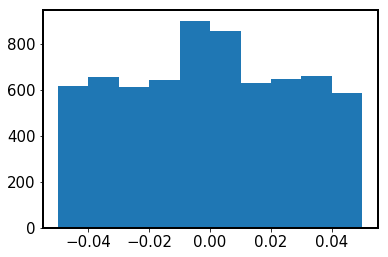

In [36]:
# so it seems just a numerical 
# rounding error: 
plt.hist(10000 * (ptf1_sdss['ra_01'] - ptf1_sdss['ra_sdss']))

Also cross match PTF2 to S82 : 

In [15]:
# ra_01 is the SDSS ra used to query PTF, same for dec_01
ptf_coords = SkyCoord(ra=ptf2['ra_01'].data.data*u.degree, 
                     dec= ptf2['dec_01'].data.data*u.degree)
sdss_coords = SkyCoord(ra=s82_stars['ra_sdss'].data.data*u.degree, 
                     dec=s82_stars['dec_sdss'].data.data*u.degree)

idx, sep2d, dist3d = ptf_coords.match_to_catalog_sky(sdss_coords) 

ptf2['d2d_arcsec']=sep2d.value*3600

ptf2_sdss = hstack([ptf2,  s82_stars[idx]])



In [118]:
#ptf2_sdss

In [119]:
# Show that all crossmatches are good
#plt.hist(ptf1_sdss['d2d_arcsec'], histtype='step', lw=2, label='PTF g-SDSS matches',
#        normed=True, bins=25, range=(0,0.05))
#plt.hist(ptf2_sdss['d2d_arcsec'], histtype='step', lw=2, label='PTF R-SDSS matches',
#        normed=True,bins=25, range=(0,0.05))
#plt.ylabel('Normed counts')
#plt.xlabel('Distance [arcsec]')
#plt.legend()

In [120]:
# These are disjoint because 
# objectIds are different between the two filters!

# Each filter is treated as a separate light curve
# because it was used primarily for transient detection 
np.sum(np.in1d(ptf1_sdss['oid'],ptf2_sdss['oid']))


0

In [43]:
pwd

'/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code'

In [44]:
# Querying Lightcurve Table rather than Objects Table ... 
# ptf_lc =  Table.read('irsa_S82_stars_lightcurves_table_results.tbl', format='ipac')
# ptf_lc.group_by('oid')

In [121]:
ptf1_sdss[:4]

cntr_01,dist_x,pang_x,ra_01,dec_01,major_01,ra,dec,oid,fid,bestmagrms,bestmaxmag,bestmeanmag,bestmedianmag,bestminmag,maxmag,meanmag,medianmag,minmag,nbestobs,ngoodobs,nobs,d2d_arcsec,raw_mjd_span,raw_mean_mag,raw_mean_err,CRTS_name,raw_lc_length,proc_mean_N_day,proc_mean_err,proc_lc_length,proc_mean_mag,proc_mjd_span,ra_crts,dec_crts,calib_fla,ra_sdss,dec_sdss,raRMS,decRMS,nEpochs,AR_val,u_Nobs,u_mMed,u_mMean,u_mErr,u_rms_scatt,u_chi2,g_Nobs,g_mMed,g_mMean,g_mErr,g_rms_scatt,g_chi2,r_Nobs,r_mMed,r_mMean,r_mErr,r_rms_scatt,r_chi2,i_Nobs,i_mMed,i_mMean,i_mErr,i_rms_scatt,i_chi2,z_Nobs,z_mMed,z_mMean,z_mErr,z_rms_scatt,z_chi2
,arcsec,deg,,,,degrees,degrees,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,str10,float64,float64,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64
1,0.299643,-54.782215,358.74966,-0.21599,0.1,358.749592,-0.215942,226961090004428,1,0.007,16.353,16.327,16.327,16.31,21.615,16.383,16.327,15.97,85,98,100,0.0237408296986,3002.94245,15.7489583333,0.0609953703704,1000037,432.0,4.03738317757,0.0313626168224,107.0,15.7431420561,3002.9233,358.7496643,-0.215985,CALIBSTARS,358.7496643,-0.215985,0.039,0.038,10,0.087,10,17.873,17.879,0.007,0.055,2.6,10,16.413,16.419,0.006,0.026,1.4,10,15.854,15.861,0.006,0.027,1.7,10,15.67,15.664,0.006,0.021,1.0,10,15.575,15.578,0.006,0.022,1.5
7,0.223223,-89.075928,358.76666,-0.43808,0.1,358.766598,-0.438079,226961090002770,1,0.015,17.761,17.724,17.725,17.686,23.941,17.793,17.725,17.638,80,93,99,0.010028184258,3002.94245,17.2121577726,0.0795823665893,1000139,431.0,4.02803738318,0.0414542056075,107.0,17.2112869159,3002.9233,358.7666626,-0.438079,CALIBSTARS,358.7666626,-0.438079,0.045,0.035,15,0.079,14,18.823,18.824,0.008,0.044,1.6,14,17.779,17.785,0.006,0.022,1.0,14,17.352,17.352,0.004,0.012,0.7,14,17.187,17.181,0.004,0.022,0.7,14,17.1,17.099,0.005,0.017,0.9
8,0.044524,-104.037904,358.7677,-0.89917,0.1,358.767688,-0.899173,226961090000991,1,0.204,21.487,20.882,20.863,20.504,21.487,20.881,20.863,20.504,82,84,84,0.0108239674914,3002.94245,19.2764918033,0.149147540984,1000148,305.0,3.05,0.108946,100.0,19.198639,3002.9245,358.7677002,-0.899173,CALIBSTARS,358.7677002,-0.899173,0.026,0.034,13,0.076,2,22.653,22.587,0.209,0.505,2.8,12,20.967,20.964,0.013,0.05,1.0,12,19.678,19.676,0.007,0.027,1.1,12,19.144,19.146,0.007,0.027,1.1,12,18.836,18.82,0.013,0.058,1.8
11,0.140021,46.03777,358.77325,-0.94053,0.1,358.773278,-0.940503,226961090000796,1,--,--,--,--,--,22.271,14.349,14.238,13.729,0,67,100,0.017707749494,3002.94245,13.7314385151,0.0501160092807,1000177,431.0,4.02803738318,0.0259102803738,107.0,13.7358102804,3002.9233,358.7732544,-0.9405322,CALIBSTARS,358.7732544,-0.9405322,0.048,0.045,6,0.078,6,15.647,15.645,0.005,0.04,0.5,6,14.337,14.34,0.01,0.011,0.3,6,13.83,13.826,0.007,0.019,1.2,6,13.623,13.622,0.006,0.014,0.8,6,13.541,13.542,0.007,0.019,0.8


In [29]:
%matplotlib inline 
def photometric_offset_sdss_survey(data, sdsscolors = 'gr', 
                                originband = 'g', targetband='r',
                                magCol = 'medianmag', 
                                errCol = 'bestmagrms' , 
                                survey = 'PTF',
                                cutoffmag = 19 , xlims = [-0.5,2.5],
                                ylims = [-0.2, 1.5], 
                                nrows=1, ncols=1, degree=1,
                                storeID = False
                               ):
    '''
    Find photometric offsets between SDSS and a survey, like
    PTF/CRTS, one band at a time. 
    
    *** Doing all offsets to SDSS r band *** 
   
    data :  a table containing ugriz SDSS photometry, cross-matched to 
            the target survey, eg. SDSS-PTF, SDSS-CRTS 
            
    sdsscolors : SDSS colors used to spread the stellar locus.  It can be 
           "gr" or "gi" (this mainly affects the x-axis limits)
           
    originband : band present in the origin survey. Eg, for PTF it's 'g', or 'R'
    
    cutoffmag : magnitude cutoff to ignore very faint stars according
          to SDSS target magnitude (eg. if yaxis is "grizz" then we filter
          by "grizz < cutoffmag" separately for each panel)
          
    xlims : limits on the x-axis in magnitudes (depends on the 
          SDSS color chosen for the x-axis). By default, [-0.5,2.5]
         
    nrows, ncols : number of rows and columns for the plot. 
    
    '''
    # SDSS data ...  using Median  magnitudes  : 
    # less susceptible to outliers 
    gmag = data['g_mMed'] 
    rmag = data['r_mMed']
    imag = data['i_mMed'] 

    
    # Fignames 
    suptitle  = 'No extinction correction'
    ext = 'ext-NO'
    
    #xaxis : 'gi' or 'gr'
    if sdsscolors is 'gr': 
        x =  gmag-rmag   # SDSS (g-r)
        xQSOlims = [-0.25, 0.75]
        xFITlims = [0.1, 1.1]
    if sdsscolors is 'gi' : 
        x = gmag-imag  # SDSS (g-i)
        xQSOlims = [ -0.2, 0.8 ]
        xFITlims = [0.25, 1.5]
        

    #yaxis : 'SDSSgrizz' or 'SDSSr'
    #if targetbands is 'r' : 
    #ymax = {'g':1.5,'r':0.2, 'i':   0,'z':0,   'y':0}
    #ymin = {'g':-0.2,'r':-0.2,'i':-0.6,'z':-0.8,'y':-0.8}

    # define the plotting space 
    fig,axs = plt.subplots(nrows,ncols, figsize=(5*ncols,4.8*nrows))
    ax = np.ravel(axs)
    i = 0 
    
    # make a table to store coefficients derived from this set of data 
    if degree == 1 : 
        coeffs  = {'x' : [], 'y' : [], 'B_0' : [], 'B_1':[]}
        
    if degree == 2 : 
        coeffs  = {'x' : [], 'y' : [], 'A_0' : [], 'A_1':[],'A_2':[]}
    
    
    # no need to loop since we're doing one filter at a time 
    # the SDSS target is 'r' only . since that's the "master band"
    f1,f2  = originband, targetband
    print(' ')
    
    # store filters used 
    coeffs['x'].append('('+sdsscolors[0]+'-'+sdsscolors[1]+')_SDSS')
    coeffs['y'].append(f1 + '_'+survey+'-'+f2+'_SDSS)')

    # remove stars that have no survey obs in that filter 
    ma = data[magCol] > 0
    print('- Removing ', np.sum(~ma) , 
          ' objects that do not have ', survey, ' obs in that filter')

    # remove faint stars to clean up the plot 
    mb = data[f2 + '_mMed'] < cutoffmag
    print('- Removing ', np.sum(~mb), 
          ' objects that are have SDSS mag fainter  than ', cutoffmag)

    # apply the two criteria from the header 
    # to stripe82calibStars_v2.6.dat : 
    ###  1) To select sources with reliable photometry in the u and z bands
    ###     don't forget to require Nobs >= 4
    ###  2) to avoid a slight bias (~0.02 mag) at the faint end in the gri  
    ###     bands, require msig*sqrt(Nobs) < 0.03 

    mc = data['u_mErr'] * np.sqrt(data['u_Nobs']) < 0.03
    print('- Removing ', np.sum(~mc), ' objects that do not fulfill ',
         ' mErr * sqrt(Nobs) < 0.03 criterion ')
    m1 = ma * mb * mc 

    if f2 is 'u' or f2 is 'z' : 
        md = data[f2+'_Nobs']  >= 4
        print('- Removing ',np.sum(~md), 
              ' objects that have less than 4 obs in  this band')
        m1 = ma * mb * mc * md 

    print('= Left with ', np.sum(m1), ' objects')
    
    
          
    # store the starID of stars used for the offset .... 
    if storeID is True : 
        name = 'StarID_'+survey+f1+'-SDSS'+f2+'_'+ext+'.txt'
        data[['starID', 'ra_sdss', 'dec_sdss']][m1].write(name, format='ascii', 
                                                overwrite=True)
        print('Stored the starIDs of all stars used for this offset as ', name )


    # no extinction correction here 
    surveyMag = data[magCol]
    sdssMag  = data[f2 + '_mMed']

    y  = surveyMag - sdssMag

    # combine errors in quadrature to use as weights in 
    # fitting with polynomial 
    e1 = data[errCol] # Survey error on the Mean 
    e2 = data[f2+'_mErr']  # SDSS standard error for the mean

    # remove stars that have no obs in that filter 
    ax[i].hexbin(x[m1],y[m1], extent= (xlims[0],xlims[1], 
                                       ylims[0], ylims[1]), bins='log'
                 )
    # add text about the filter combination being plotted 
    #ax[i].text(x = 0.1, y=0.1, s = f1+survey+'-'+f2+'SDSS', 
    #       color='yellow', fontsize=17, transform=ax[i].transAxes)

    # mark with vertical lines  the range occupied by QSO
    # the y limits are in axis coords 
    ax[i].axvline(xQSOlims[0], ymin=0.25, ymax=0.85 , ls='--', lw=2, c='orange')
    ax[i].axvline(xQSOlims[1], ymin=0.25, ymax=0.85, ls='--', lw=2, c='orange')

    # make my own linear fits 
    m2 = (xFITlims[0]<x)*(x<xFITlims[1]) # within the vertical dashed lines 
    m3 = (ylims[0] < y) *(y < ylims[1]) # within the ylims of the plot 
    m_ = m1*m2*m3

    # fit n-th degree polynomial
    xf  = x[m_] ;  yf=y[m_] ; ef = np.sqrt(e1[m_]**2.0 + e2[m_]**2.0)
    
    p = np.polyfit(xf,yf,deg=degree, w=1/ef)
     
    if degree == 1 : 
        # y = B_0 + B_1 * x as  in Tonry+2012 
        coeffs['B_1'].append(p[0]) 
        coeffs['B_0'].append(p[1])  
        x_ = np.linspace(xFITlims[0],xFITlims[1], 100)
        ax[i].plot(x_, p[0] *x_ + p[1]  , c='red')
    
    if degree == 2 : 
        # y = A_0 + A_1 * x  + A_2*x*x in Tonry+2012 
        coeffs['A_2'].append(p[0]) 
        coeffs['A_1'].append(p[1]) 
        coeffs['A_0'].append(p[2])
        x_ = np.linspace(xFITlims[0],xFITlims[1], 100)
        ax[i].plot(x_, p[0] *x_*x_ + p[1] *x_ + p[2] , c='red')
    
    # add axis labels ... 
    ax[i].set_xlabel('('+sdsscolors[0]+'-'+sdsscolors[1]+') SDSS ', 
                     fontsize=17)
    ax[i].set_ylabel(survey+'('+f1+')'+'-SDSS ('+f2+')', fontsize=17, rotation=90)
    
    # Save the figure ... 
    
    fig.suptitle(suptitle, fontsize=18)
    figtitle = 'Offsets_'+survey+f1+'-SDSS'+f2+'_SDSS'+sdsscolors+'_'+ext+'.png'
    print('Figure saved as ', figtitle)
    plt.savefig(figtitle,
               bbox_inches='tight')
    
    c  = Table(coeffs)
    tabtitle = 'Offsets_'+survey+f1+'-SDSS'+f2+'_SDSS'+sdsscolors+'_'+ext+'.txt'
    c.write(tabtitle, format='ascii', overwrite='True')
    print('Coefficients stored as an ascii table ', tabtitle)
    

PTF(g)  to SDSS(r) synthetic,  using SDSS(g-i) color 

 
- Removing  27  objects that do not have  PTF  obs in that filter
- Removing  991  objects that are have SDSS mag fainter  than  20
- Removing  4536  objects that do not fulfill   mErr * sqrt(Nobs) < 0.03 criterion 
= Left with  2023  objects
Figure saved as  Offsets_PTFg-SDSSr_SDSSgi_ext-NO.png
Coefficients stored as an ascii table  Offsets_PTFg-SDSSr_SDSSgi_ext-NO.txt


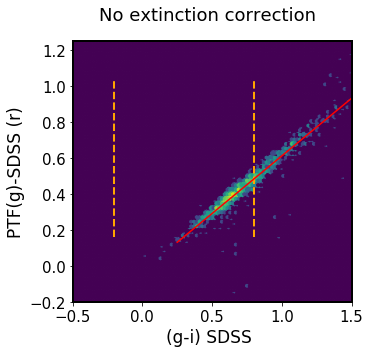

In [17]:
photometric_offset_sdss_survey(ptf1_sdss, sdsscolors = 'gi', originband = 'g',
                               magCol = 'medianmag', errCol = 'bestmagrms' , 
                               survey = 'PTF', cutoffmag = 20 , 
                               xlims = [-0.5,1.5], ylims= [-0.2, 1.25],
                               nrows=1, ncols=1 , degree=1
                               )

PTF(R)  to SDSS(r) synthetic,  using SDSS(g-i) color 

 
- Removing  35  objects that do not have  PTF  obs in that filter
- Removing  12346  objects that are have SDSS mag fainter  than  20
- Removing  15756  objects that do not fulfill   mErr * sqrt(Nobs) < 0.03 criterion 
= Left with  7636  objects
Figure saved as  Offsets_PTFR-SDSSr_SDSSgi_ext-NO.png
Coefficients stored as an ascii table  Offsets_PTFR-SDSSr_SDSSgi_ext-NO.txt


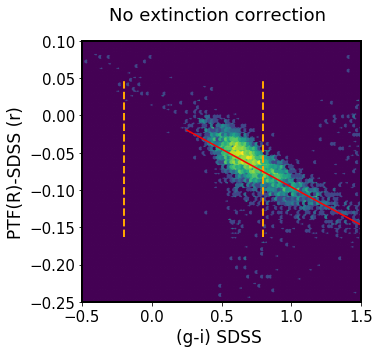

In [18]:
photometric_offset_sdss_survey(ptf2_sdss, sdsscolors = 'gi', originband = 'R',
                               magCol = 'medianmag', errCol = 'medianabsdev' , 
                               survey = 'PTF', cutoffmag = 20 , 
                               xlims = [-0.5,1.5], ylims= [-0.25, 0.1],
                               nrows=1, ncols=1, degree=1
                               )

Overlapping stars... 

In [24]:
g = Table.read('StarID_PTFg-SDSSr_ext-NO.txt', format='ascii')
R  = Table.read('StarID_PTFR-SDSSr_ext-NO.txt', format='ascii')


In [46]:
g[np.in1d(g['starID'], R['starID'])].write('StarID_PTFgR-SDSSr.txt', 
                                                   format='ascii')

Not much - only 116 stars that were used to derive PTFg-SDSSr offset were also used to derive PTFR-SDSSr offst! 

CRTS(V) to SDSS(r) via SDSS(g-i) color 

In [6]:
s82_stars[:4]

raw_mjd_span,raw_mean_mag,raw_mean_err,CRTS_name,raw_lc_length,proc_mean_N_day,proc_mean_err,proc_lc_length,proc_mean_mag,proc_mjd_span,ra_crts,dec_crts,calib_fla,ra_sdss,dec_sdss,raRMS,decRMS,nEpochs,AR_val,u_Nobs,u_mMed,u_mMean,u_mErr,u_rms_scatt,u_chi2,g_Nobs,g_mMed,g_mMean,g_mErr,g_rms_scatt,g_chi2,r_Nobs,r_mMed,r_mMean,r_mErr,r_rms_scatt,r_chi2,i_Nobs,i_mMed,i_mMean,i_mErr,i_rms_scatt,i_chi2,z_Nobs,z_mMed,z_mMean,z_mErr,z_rms_scatt,z_chi2
float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,str10,float64,float64,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64
3020.85593,17.8823529412,0.0705147058824,251,136.0,3.4,0.0399875,40.0,17.8839675,3020.8452,0.040063,0.55537,CALIBSTARS,0.040063,0.55537,0.038,0.031,9,0.068,9,19.069,19.062,0.009,0.047,2.0,9,18.253,18.251,0.007,0.016,0.6,9,17.919,17.919,0.006,0.014,0.6,9,17.788,17.79,0.006,0.01,0.2,9,17.731,17.734,0.008,0.02,0.7
2892.13763,15.2544047619,0.05,340,84.0,4.0,0.025,21.0,15.2544047619,2892.1202,0.054511,-1.1499029,CALIBSTARS,0.054511,-1.1499029,0.049,0.067,9,0.097,9,17.772,17.77,0.007,0.018,0.7,9,16.012,16.01,0.006,0.014,0.5,9,15.319,15.318,0.006,0.01,0.3,9,15.056,15.057,0.005,0.013,0.5,9,14.938,14.942,0.006,0.016,0.9
3020.85593,17.8416666667,0.0703623188406,425,138.0,3.45,0.039565,40.0,17.84158,3020.8438,0.073721,0.404988,CALIBSTARS,0.073721,0.404988,0.058,0.057,14,0.071,2,22.361,22.358,0.181,0.127,0.2,13,19.855,19.857,0.007,0.033,1.6,13,18.325,18.322,0.005,0.024,1.0,13,17.166,17.171,0.004,0.016,1.1,13,16.54,16.543,0.005,0.024,1.2
3020.85593,19.4547826087,0.113115942029,455,138.0,3.45,0.0637025,40.0,19.4524925,3020.8438,0.078358,0.235094,CALIBSTARS,0.078358,0.235094,0.032,0.036,13,0.085,0,-0.33,-0.33,0.0,0.0,0.0,12,20.936,20.937,0.011,0.03,0.5,12,19.601,19.602,0.007,0.033,1.8,12,18.961,18.971,0.006,0.023,1.6,12,18.615,18.601,0.013,0.066,2.1


 
- Removing  0  objects that do not have  CRTS  obs in that filter
- Removing  4844  objects that are have SDSS mag fainter  than  21
- Removing  24036  objects that do not fulfill   mErr * sqrt(Nobs) < 0.03 criterion 
= Left with  20916  objects
Figure saved as  Offsets_CRTSV-SDSSr_SDSSgi_ext-NO.png
Coefficients stored as an ascii table  Offsets_CRTSV-SDSSr_SDSSgi_ext-NO.txt


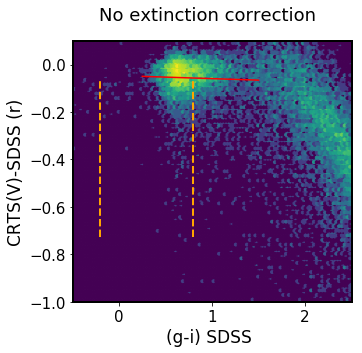

In [37]:
photometric_offset_sdss_survey(s82_stars, sdsscolors = 'gi', originband = 'V',
                               targetband='r',
                               magCol = 'raw_mean_mag', errCol = 'raw_mean_err' , 
                               survey = 'CRTS', cutoffmag =21 , 
                               xlims = [-0.5,2.5], ylims= [-1, 0.1],
                               nrows=1, ncols=1, degree=1
                               )

 
- Removing  0  objects that do not have  CRTS  obs in that filter
- Removing  17636  objects that are have SDSS mag fainter  than  20
- Removing  23565  objects that do not fulfill   mErr * sqrt(Nobs) < 0.03 criterion 
= Left with  11188  objects
Stored the starIDs of all stars used for this offset as  StarID_CRTSV-SDSSr_ext-NO.txt
Figure saved as  Offsets_CRTSV-SDSSr_SDSSgi_ext-NO.png
Coefficients stored as an ascii table  Offsets_CRTSV-SDSSr_SDSSgi_ext-NO.txt


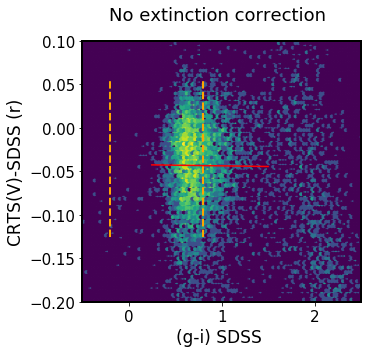

In [32]:
photometric_offset_sdss_survey(s82_stars, sdsscolors = 'gi', originband = 'V',
                               targetband='r',
                               magCol = 'raw_mean_mag', errCol = 'raw_mean_err' , 
                               survey = 'CRTS', cutoffmag =20 , 
                               xlims = [-0.5,2.5], ylims= [-0.2, 0.1],
                               nrows=1, ncols=1, degree=1
                               )

Very flat  - it's almost the same ! 

In [33]:
crts_ids = Table.read('StarID_CRTSV-SDSSr_ext-NO.txt', format='ascii')

In [40]:
ps1_ids = np.loadtxt('PS1gri_SDSSr_starIDs_used.txt',)

In [50]:
overlap  = np.in1d(crts_ids['starID'],ps1_ids.astype(int))
np.sum(overlap)

6695

In [51]:
# Stars that were used to derive offsets for CRTS, PS1 gri : 
ps1_crts  = crts_ids[overlap]

That's a good overlap - so even though PTF between each band do not have much overlap, PS1 do, and they have much in common with CRTS. 

In [47]:
ptf_ids =  Table.read('StarID_PTFgR-SDSSr.txt', format='ascii')

In [54]:
overlap = np.in1d(ptf_ids['starID'], ps1_crts['starID'])
np.sum(overlap)
ptf_ids[overlap].write('StarID_PTF_CRTS_PS1-to_SDSS_overlap.txt', format='ascii')

Ok, these 81 stars were used to derive all offsets : PS1 gri,  CRTS, and PTF gR.   Pull their light curves from all surveys, and apply offsets , to show how the pipeline performs ... 

In [4]:
stars_to_download = Table.read('StarID_PTF_CRTS_PS1-to_SDSS_overlap.txt',
                              format='ascii')

In [5]:
stars_to_download  # from PTF and PS1 ... 

starID,ra_sdss,dec_sdss
int64,float64,float64
782619,20.1726341,-1.1254089
692319,2.1529219,-0.844379
795598,23.1087093,-0.768104
695398,2.2424421,-0.904605
694691,2.530575,-0.387433
823043,28.3637962,-1.1345879
697314,2.7475851,-0.189224
869172,36.4527168,-0.116482
867935,36.5218506,-0.983534


In [7]:
# Store as IPAC table 
stars_to_download.rename_column('ra_sdss', 'ra')
stars_to_download.rename_column('dec_sdss', 'dec')
stars_to_download.write('StarID_PTF_CRTS_PS1-to_SDSS_overlap.tbl', format='ipac',
                       overwrite=True)

PTF data :
   * go to https://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-scan?submit=Select&projshort=PTF
   * select PTF Lightcurve Table  
   * select Multi-Object Search,  set cone search radius to 2 arcsec 
   * download : 2996 rows matching the input 
    
PS1 data  : 
   * go to MAST archive http://mastweb.stsci.edu/ps1casjobs/SubmitJob.aspx
     * note : a wealth of info at https://outerspace.stsci.edu/display/PANSTARRS/PS1+Glossary+of+PS1-specific+terms  and https://panstarrs.stsci.edu  CASJobs guide  https://mastweb.stsci.edu/ps1casjobs/guide.aspx  - based on that info it looks like there is no light curves available yet! " The DR2 source database will allow users to extract information on any time variation of source photometry."  -  which is planned to be by the end of 2018 ... 
   * login with user: suberlak , pass: ei....
   * go to `Import`,  upload the list of starID, ra, dec `StarID_PTF_CRTS_PS1-to_SDSS_overlap.txt `, ingest it as a database - it appears in `MyDB`
   * in `MyDB`, I can preview the PanStarrs1 tables, to know what to choose for light curve query... 
   * EXIT : no light curves in DR1  !!!  Very fine print, but that's the truth. Blah....


SDSS data : 
  * go to  https://skyserver.sdss.org/CasJobs/SubmitJob.aspx   , suberlak,  ein  to login
    * an example time series query : http://skyserver.sdss.org/dr14/en/help/docs/realquery.aspx#timeseries 
  http://skyserver.sdss.org/dr14/en/help/howto/search/functions.aspx 
    * advanced queries http://skyserver.sdss.org/casjobs/aqueries.aspx 
   * go to `Import` , upload the list of starID, ra, dec `StarID_PTF_CRTS_PS1-to_SDSS_overlap.txt `, ingest it as a database - it appears in `MyDB`
  

In [32]:
# PTF standard stars 
ptf = Table.read('irsa_81_standard_stars_PTF.tbl', format='ipac')

# this table already has the SDSS starid,  ra, dec, all of which have a
# name starid_01,  ra_01,  dec_01 


In [21]:
# 'ra_01' is the SDSS ra, while 'ra' is the PTF ra 
# assert np.sum(np.bitwise_not(np.in1d(ptf['ra_01'], stars_to_download['ra']))) == 0 
# each star has  a PTF match  :
# assert len(np.unique(ptf['ra_01'])) == len(stars_to_download)

0